# Clustering Model

### Main Research Question: 

**How can movie profiling, based on a comprehensive set of characteristics, facilitate more accurate predictions and personalised recommendations for different audience preferences?**

### Sub-questions:

1 - Which model performs best at profiling movies based on their characteristics?

2 - Do the models perform better by reducing dimensinality on PCs or important features?

3 - How can the age of the movies distributed be used for creating movie profiles?

4 - How can the userscore be used for creating movie profiles?

5 - How can the metascore be used for creating movie profiles?

6 - How can the release month be used for creating movie profiles?

7 - How can the amount of top actors be used for creating movie profiles?

# Table of contents 

###  1. Import libraries 
          1.1 Encoding
###  2. Dimensionality reduction
         2.1 Important PCs (Explained variance) 
         2.2 Important Features
###  3. K-means
         3.1 Important PCs
             3.1.1 Optimizing Cluster Analysis using the Elbow Method
             3.1.2 Building final model 
         3.2 Important Features
             3.2.1 Optimizing Cluster Analysis using the Elbow method 
             3.2.2 Building final model 
         3.3 Model Evaluation 
         3.4 Visualisation 
###  4. DBSCAN
         4.1 Important PCs 
             4.1.1 Building final model 
         4.2 Important Features
             4.2.1 Building final model
         4.3 Model evaluation
###  5. HDBSCAN 
         5.1 Important PCs 
             5.1.1 Grid search 
             5.1.2 Building model 
         5.2 Important features
             5.2.1 Grid search 
             5.2.2 Building final model 
         5.3 Model evaluation 
         5.4 Answer on the research question and subquestions
###  6. Model interpretation 
         6.1 Cluster Summary and description 
         6.2 Answers on the research question and sub-questions

## 1. Import libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors 
! pip install hdbscan
import hdbscan
from sklearn.metrics import silhouette_score
import matplotlib.gridspec as gridspec

In [2]:
from IPython.core.display import HTML # to pretty print pandas df and be able to copy them over (e.g. to ppt slides)

In [3]:
# Loading the CSV file into a pandas DataFrame
file_path = r"c:\Users\leath\Documents\AUAS\0. Completed\7. AI Methods in Business\Resit\Movie_Cleaned.csv"
movie_df = pd.read_csv(file_path)

# Checking the first few rows of the dataframe
movie_df.head()

,title,studio,rating,director,genre,metascore,userscore,Age,RelMonth,top_actors_count
0,!Women Art Revolution,Hotwire Productions,Not Rated,Lynn Hershman-Leeson,Documentary,70,7.097753,13,6,0
1,10 Cloverfield Lane,Paramount Pictures,PG-13,Dan Trachtenberg,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror",76,7.700000,8,3,1
2,10 Items or Less,Click Star,R,Brad Silberling,"Drama,Comedy,Romance",54,5.800000,18,12,0
3,10 Years,Anchor Bay Entertainment,R,Jamie Linden,"Drama,Comedy,Romance",61,6.900000,12,9,0
4,100 Bloody Acres,Music Box Films,Not Rated,Cameron Cairnes,"Horror,Comedy",63,7.500000,11,6,0


### 1.1 Encoding

In [4]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

genres = movie_df['genre'].astype(str)

# Split and explode the genre names
all_genres = genres.str.split(',').explode().str.strip()

# Extract and count the occurrences of individual genres
genre_counts = all_genres.value_counts()

# Choose the top 10 most frequent genres
top_genres = genre_counts.head(10).index.tolist()

# Create a TF-IDF vectorizer with the filtered genres
tfidf_vectorizer = TfidfVectorizer(stop_words='english', vocabulary=top_genres)
tfidf_matrix = tfidf_vectorizer.fit_transform(genres)

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Concatenate the TF-IDF DataFrame with the original DataFrame
movie_df = pd.concat([movie_df, tfidf_df], axis=1)

c:\Users\leath\anaconda3\python\Lib\site-packages\sklearn\feature_extraction\text.py:1375: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [5]:
# Checking the first few rows of the dataframe
movie_df.head()

,title,studio,rating,director,genre,metascore,userscore,Age,RelMonth,top_actors_count,Drama,Comedy,Thriller,Documentary,Romance,Action,Crime,Adventure,Horror,Biography
0,!Women Art Revolution,Hotwire Productions,Not Rated,Lynn Hershman-Leeson,Documentary,70,7.097753,13,6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10 Cloverfield Lane,Paramount Pictures,PG-13,Dan Trachtenberg,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror",76,7.700000,8,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10 Items or Less,Click Star,R,Brad Silberling,"Drama,Comedy,Romance",54,5.800000,18,12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10 Years,Anchor Bay Entertainment,R,Jamie Linden,"Drama,Comedy,Romance",61,6.900000,12,9,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100 Bloody Acres,Music Box Films,Not Rated,Cameron Cairnes,"Horror,Comedy",63,7.500000,11,6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Removing the 'genre' and 'title' column
movie_df.drop(['genre', 'title'], inplace=True, axis=1)

In [7]:
movie_df.dtypes

studio               object
rating               object
director             object
metascore             int64
userscore           float64
Age                   int64
RelMonth              int64
top_actors_count      int64
Drama               float64
Comedy              float64
Thriller            float64
Documentary         float64
Romance             float64
Action              float64
Crime               float64
Adventure           float64
Horror              float64
Biography           float64
dtype: object

In [8]:
# Select only categorical columns
categorical_df = movie_df.select_dtypes(include='object')

# Count unique values for each categorical column
unique_counts = categorical_df.nunique()

# Display the unique counts
print(unique_counts)

studio      1119
rating        14
director    6137
dtype: int64


As there are too many unique values for director and studio, those features will be given ordinal values instead of doing one hot encoding to not create over 7000 new columns. This will only be done for rating as it only creates 14 new columns.

In [9]:
# Encoding for 'studio' column
moviestudio = movie_df['studio'].astype(str)
unique_studios = moviestudio.unique()
studio_mapping = {studio: i for i, studio in enumerate(unique_studios)}
movie_df['studio'] = moviestudio.map(studio_mapping)

# Encoding for 'director' column
moviedirector = movie_df['director'].astype(str)
unique_directors = moviedirector.unique()
director_mapping = {director: i for i, director in enumerate(unique_directors)}
movie_df['director'] = moviedirector.map(director_mapping)

In [10]:
from sklearn.preprocessing import OneHotEncoder

# Columns for One-Hot Encoding
columns_to_encode = ['rating']

# Extract the columns to be encoded
data_to_encode = movie_df[columns_to_encode]

# Create the OneHotEncoder instance
one_hot_encoder = OneHotEncoder(sparse=False, drop='first')

# Fit and transform the data using the encoder
encoded_data = one_hot_encoder.fit_transform(data_to_encode)

# Get the feature names after encoding
encoded_column_names = one_hot_encoder.get_feature_names_out(columns_to_encode)

# Create a DataFrame with the encoded data and appropriate column names
encoded_df = pd.DataFrame(encoded_data, columns=encoded_column_names)

# Concatenate the encoded DataFrame with the original DataFrame
movie_df = pd.concat([movie_df.drop(columns=columns_to_encode), encoded_df], axis=1)

# Display the updated DataFrame with encoded columns
movie_df.head()

c:\Users\leath\anaconda3\python\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,studio,director,metascore,userscore,Age,RelMonth,top_actors_count,Drama,Comedy,Thriller,...,rating_ NC-17,rating_ NR,rating_ Not Rated,rating_ PG-13,rating_ PG-13`,rating_ R,rating_ TV-14,rating_ TV-G,rating_ TV-MA,rating_ TV-PG
0,0,0,70,7.097753,13,6,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,76,7.700000,8,3,1,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,54,5.800000,18,12,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3,3,61,6.900000,12,9,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4,4,63,7.500000,11,6,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# scaling the features with StandardScaler
from sklearn.preprocessing import StandardScaler
# define standard scaler instance
scaler = StandardScaler()
# Fitting the StandardScaler to transaction_df_encoded
scaler.fit(movie_df)
# Scaling df used the fitting Standard scalar
df_scaled = pd.DataFrame(scaler.transform(movie_df), columns=movie_df.columns)

## 2. Dimensionality reduction

### 2.1 Important PCs (Explained variance)

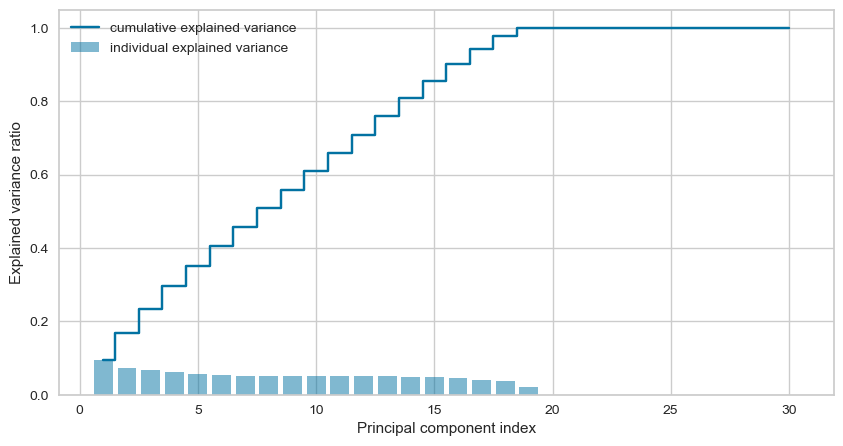

In [12]:
# Performing PCA
pca = PCA()  # Initializing the PCA object

# pca_comps: Transforming the scaled data using PCA to obtain principal components
pca_comps = pca.fit_transform(df_scaled)

# var_exp: Extracting the explained variance ratio for each principal component
var_exp = pca.explained_variance_ratio_

# cum_var_exp: Calculating the cumulative explained variance for all principal components
cum_var_exp = np.cumsum(var_exp)

# Plotting the explained variances
fig = plt.figure(figsize=(10, 5), dpi=100)  # Creating a figure object for the plot
plt.bar(range(1, len(var_exp) + 1), var_exp, alpha=0.5, align='center', label='individual explained variance')

# Plotting individual explained variance for each principal component as bars
plt.step(range(1, len(var_exp) + 1), cum_var_exp, where='mid', label='cumulative explained variance')

# Plotting cumulative explained variance as a step graph
plt.ylabel('Explained variance ratio')  # Label for y-axis
plt.xlabel('Principal component index')  # Label for x-axis
plt.legend(loc='best')  # Adding legend to the plot
plt.show()  # Displaying the plot

In [13]:
# Setting the desired variance explained threshold to 85%
var_exp_thres = 0.85  

# Calling the PCA instance with the desired variance explained threshold
pca = PCA(var_exp_thres)  # Creating a PCA object with the specified variance threshold

# Transforming the scaled data using PCA to obtain principal components
pca_comps = pca.fit_transform(df_scaled)

# Printing the number of components required to explain the specified variance threshold
print('Number of components to explain {:0.0f}% variance is {}'.format(var_exp_thres * 100, pca.n_components_))

Number of components to explain 85% variance is 15


### 2.2 Important Features

In [14]:
most_important_features_idx = [np.abs(pca.components_[i]).argmax() for i in range(pca.n_components_)]
most_important_features = df_scaled.columns[most_important_features_idx]

print('The most important features are:', most_important_features.values)

The most important features are: ['rating_ Not Rated' 'userscore' 'rating_ PG-13' 'Age' 'rating_ M/PG'
 'rating_ M/PG' 'rating_ G' 'rating_ NC-17' 'rating_ TV-PG'
 'rating_ TV-14' 'rating_ TV-G' 'rating_ PG-13`' 'rating_ MA-17'
 'rating_ TV-PG' 'RelMonth']


## 3. K-means

### 3.1 Important PCs

#### 3.1.1 Optimizing Cluster Analysis using the Elbow Method

c:\Users\leath\anaconda3\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\leath\anaconda3\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\leath\anaconda3\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\leath\anaconda3\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'au

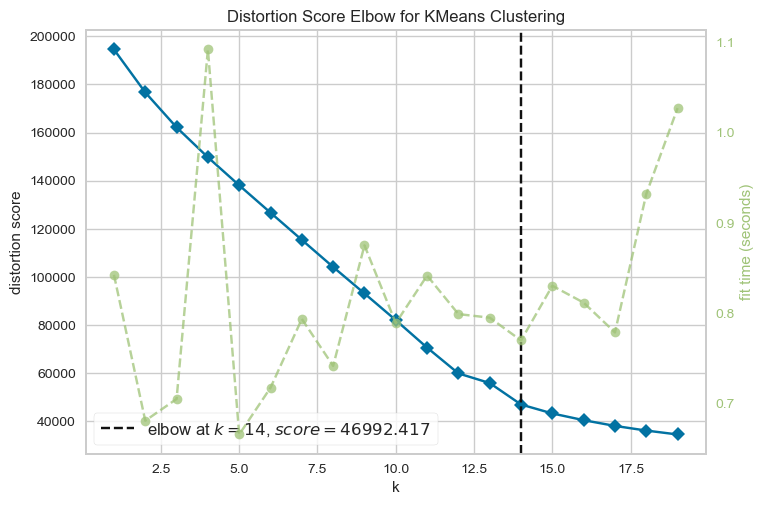

The best cluster number is: 14


In [15]:
# Performing the Elbow Method for determining the optimal number of clusters

# Instantiate the KMeans clustering model and KElbowVisualizer
kmeans = KMeans(random_state=3092)  # Initialize KMeans with a random state 
visualizer = KElbowVisualizer(kmeans, k=(1, 20))  # Create the KElbowVisualizer for cluster range (4 to 12)

visualizer.fit(pca_comps)  # Fit the PCA-transformed data to the visualizer for clustering evaluation

visualizer.show()  # Render and display the Elbow plot to visualize the optimal cluster number

# Print the determined best cluster number obtained from the Elbow Method
print('The best cluster number is:', visualizer.elbow_value_)

#### 3.1.2 Building final model

We therefore perform the K-means model on 14 clusters.

In [16]:
kmeans_best_cluster = KMeans(n_clusters=visualizer.elbow_value_)
kmeans_best_cluster.fit(pca_comps)
#saving the cluster labels
Kmeans_clusters_PCs = kmeans_best_cluster.labels_

c:\Users\leath\anaconda3\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### 3.2 Important features

#### 3.2.1 Optimizing Cluster Analysis using the Elbow Method

c:\Users\leath\anaconda3\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\leath\anaconda3\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\leath\anaconda3\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\leath\anaconda3\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'au

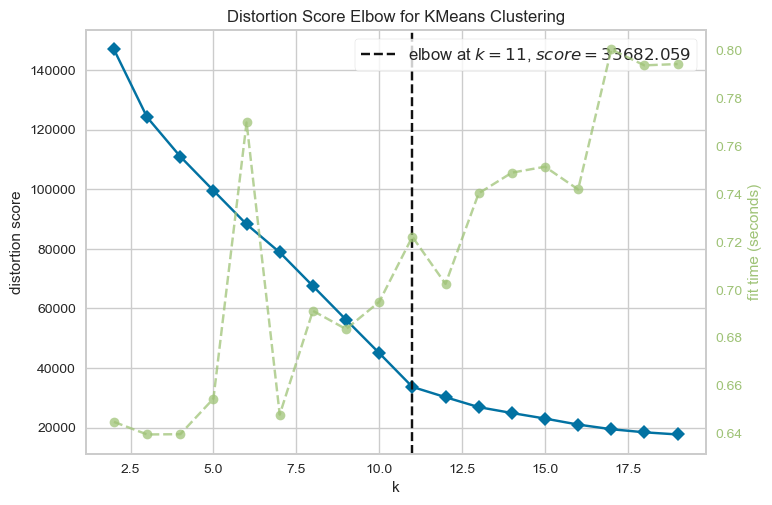

The best cluster number is: 11


In [17]:
# Cluster Analysis using Elbow Method

# Instantiate the KMeans clustering model and the KElbowVisualizer
kmeans = KMeans(random_state=3092)  # Initialize KMeans with a specified random state
visualizer = KElbowVisualizer(kmeans, k=(2, 20))  # Create the KElbowVisualizer for a range of clusters (4 to 12)

# Fit the important features data to the visualizer for cluster evaluation
visualizer.fit(df_scaled[most_important_features])

visualizer.show()  # Display the Elbow plot for visualizing optimal cluster selection

# Get the determined best cluster number using the Elbow Method
elbow_value = visualizer.elbow_value_

print('The best cluster number is:', elbow_value)  # Print the determined best cluster number

#### 3.2.2 Building final model

We therefore perform the K-means model on 11 clusters.

In [18]:
# Perform KMeans Clustering with Optimal Number of Clusters (11 clusters)

# Instantiate KMeans with the determined optimal number of clusters
kmeans_best_cluster = KMeans(n_clusters=visualizer.elbow_value_)

# Fit KMeans using the most important features' scaled data for clustering
kmeans_best_cluster.fit(df_scaled[most_important_features])

# Save the cluster labels generated by KMeans using important features
Kmeans_clusters_ImpFeatures = kmeans_best_cluster.labels_

c:\Users\leath\anaconda3\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### 3.3 Model evaluation

In [19]:
from sklearn import metrics
dbi = []

#metrics from imporant PC features method
dbi.append(metrics.davies_bouldin_score(pca_comps, Kmeans_clusters_PCs))

#metrics from imporant features from PCA method
dbi.append(metrics.davies_bouldin_score(df_scaled[most_important_features], Kmeans_clusters_ImpFeatures))

clusteting_methods = ['Kmean_on_PCs', 'Kmean_on_ImpFeatures']

# Creating a pandas dataframe
d = {'DBI': dbi, 'clusteting_methods':clusteting_methods}
df_metrics = pd.DataFrame(d)
df_metrics.set_index('clusteting_methods', inplace = True)
df_metrics

,DBI
clusteting_methods,
Kmean_on_PCs,0.629029
Kmean_on_ImpFeatures,0.539409


Conclusion: The K-mean on important features performs better than the K-mean on PCs.

### 3.4 Visualisation

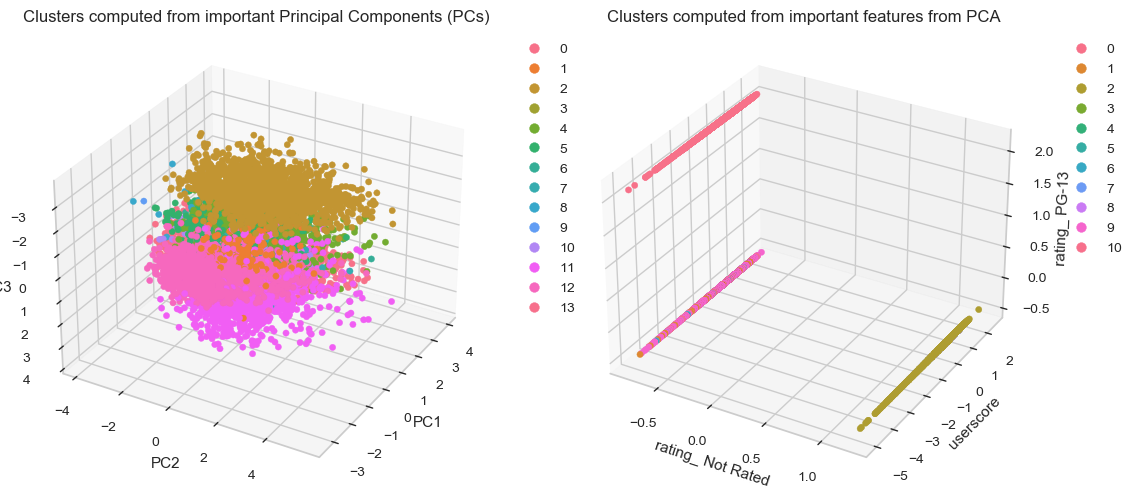

In [20]:
# Define the colormap using the 'husl' color palette
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# Create a figure with three subplots for 3D scatter plots
fig = plt.figure(figsize=(20, 7.5), dpi=100)

# Plotting the first subplot - Clusters computed from important Principal Components (PCs)
ax = fig.add_subplot(1, 3, 1, projection='3d')  
scatter = ax.scatter(
    pca_comps[:, 0], pca_comps[:, 1], pca_comps[:, 2],
    c=Kmeans_clusters_PCs, marker='o', cmap=cmap, alpha=1
)
ax.set_xlabel('PC1')  
ax.set_ylabel('PC2')  
ax.set_zlabel('PC3')  
ax.set_title('Clusters computed from important Principal Components (PCs)')  
ax.legend(*scatter.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)  
ax.view_init(-150, -30)  # Set the viewing angle

# Plotting the second subplot - Clusters computed from important features from PCA
ax = fig.add_subplot(1, 3, 2, projection='3d') 
scatter = ax.scatter(
    df_scaled[most_important_features[0]], df_scaled[most_important_features[1]], df_scaled[most_important_features[2]],
    c=Kmeans_clusters_ImpFeatures, marker='o', cmap=cmap, alpha=1
)
ax.set_xlabel(most_important_features[0]) 
ax.set_ylabel(most_important_features[1])  
ax.set_zlabel(most_important_features[2])  
ax.set_title('Clusters computed from important features from PCA')  
ax.legend(*scatter.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)  

plt.show()  # Display the 3D scatter plots


## 4. DBSCAN

### 4.1 Important PCs

We will try to find the best epsilon with the elbow method.

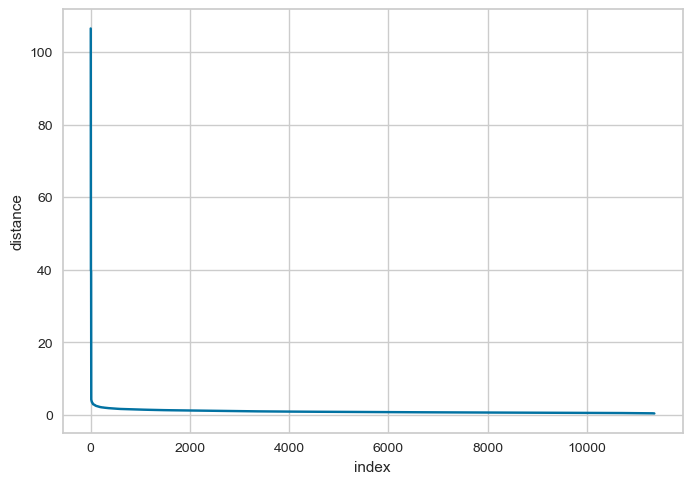

In [21]:
# Determine the minimum number of samples for DBSCAN clustering
min_samples = pca_comps.shape[1] + 1  # P represents the number of features
k = min_samples
knn_fit = NearestNeighbors(n_neighbors=k).fit(pca_comps)
distances, indices = knn_fit.kneighbors(pca_comps) # distances are the distance of each point from k nearest neighbors, sorted in ascending order
further_neighbor = distances[:,-1] = distances[:,-1]
further_neighbor[::-1].sort() #sorting the distance in descending order

#ploting the elbow method plot
plt.plot(further_neighbor)
plt.xlabel('index')
plt.ylabel('distance')
plt.grid(visible=True, which='both')
plt.show()

As the elbow is not readable, a grid search will be performed.

In [22]:
# Define a range of epsilon values to search
epsilon_values = np.linspace(0.1, 2.0, 20)

best_eps = None
best_cluster_count = 0

for eps in epsilon_values:
    # Build the DBSCAN model with specified epsilon and minimum samples
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Perform DBSCAN clustering on the entire dataset
    db_clusters = dbscan.fit_predict(pca_comps)

    # Count unique clusters created by DBSCAN with the current epsilon
    unique_clusters_count = len(set(db_clusters))

    # Update best epsilon and cluster count if a better candidate is found
    if unique_clusters_count > best_cluster_count:
        best_cluster_count = unique_clusters_count
        best_eps = eps

# Display the best epsilon and corresponding cluster count found during the grid search
print(f"Best epsilon found: {best_eps}")
print(f"Corresponding cluster count: {best_cluster_count}")

Best epsilon found: 0.7
Corresponding cluster count: 14


#### 4.1.1 Building final model

In [23]:
#DBSCAN final model building 
dbscan = DBSCAN(eps = 0.7, min_samples = min_samples)
db_clusters_PCs = dbscan.fit_predict(pca_comps)
print('dbscan has created clusters:', list(set(db_clusters_PCs)))

dbscan has created clusters: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1]


DBSCAN created 13 clusters + noise for important PCs.

### 4.2 Important features

We will try to find the best epsilon with the elbow method.

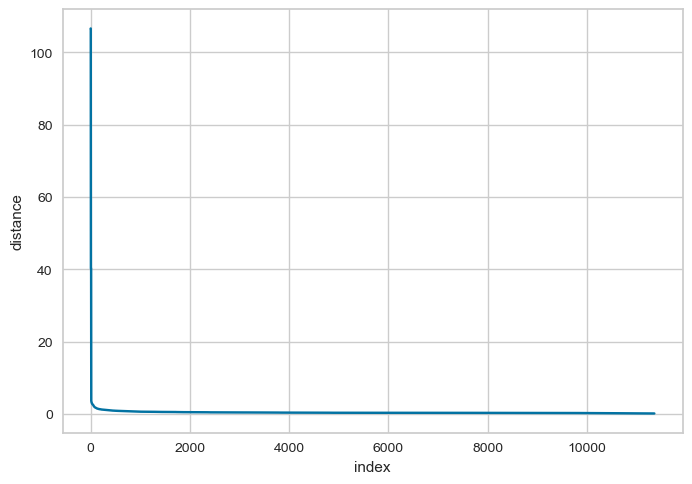

In [24]:
k = min_samples
knn_fit = NearestNeighbors(n_neighbors=k).fit(df_scaled[most_important_features])
distances, indices = knn_fit.kneighbors(df_scaled[most_important_features]) # distances are the distance of each point from k nearest neighbors, sorted in ascending order
further_neighbor = distances[:,-1] = distances[:,-1]
further_neighbor[::-1].sort() #sorting the distance in descending order

#ploting the elbow method plot
plt.plot(further_neighbor)
plt.xlabel('index')
plt.ylabel('distance')
plt.grid(visible=True, which='both')
plt.show()

As the elbow is not readable, a grid search will be performed.

In [25]:
# Extract the selected features from the DataFrame
selected_features = df_scaled[most_important_features]

# Define a range of epsilon values to search
epsilon_values = np.linspace(0.1, 2.0, 20)

best_eps = None
best_cluster_count = 0

for eps in epsilon_values:
    # Build the DBSCAN model with specified epsilon and minimum samples
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Perform DBSCAN clustering on the selected features
    db_clusters = dbscan.fit_predict(selected_features)

    # Count unique clusters created by DBSCAN with the current epsilon
    unique_clusters_count = len(set(db_clusters))

    # Update best epsilon and cluster count if a better candidate is found
    if unique_clusters_count > best_cluster_count:
        best_cluster_count = unique_clusters_count
        best_eps = eps

# Display the best epsilon and corresponding cluster count found during the grid search
print(f"Best epsilon found: {best_eps}")
print(f"Corresponding cluster count: {best_cluster_count}")

Best epsilon found: 0.3
Corresponding cluster count: 52


#### 4.2.1 Building final model

In [26]:
#DBSCAN final model building 
dbscan = DBSCAN(eps = 0.3, min_samples = min_samples)
db_clusters_ImpFeatures = dbscan.fit_predict(df_scaled[most_important_features])
print('dbscan has created clusters:', list(set(db_clusters_ImpFeatures)))

dbscan has created clusters: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, -1]


DBSCAN created 51 clusters + noise for important features.

### 4.3 Model evaluation

In [27]:
#metrics from imporant PC features method
dbi.append(metrics.davies_bouldin_score(pca_comps, db_clusters_PCs))
clusteting_methods.append('DBSCAN_on_PCs')

#metrics from imporant features from PCA method
dbi.append(metrics.davies_bouldin_score(df_scaled[most_important_features], db_clusters_ImpFeatures))
clusteting_methods.append('DBSCAN_on_ImpFeatures')

# Creating a pandas dataframe
d = {'DBI': dbi, 'clusteting_methods':clusteting_methods}
df_metrics = pd.DataFrame(d)
df_metrics.set_index('clusteting_methods', inplace = True)
df_metrics

,DBI
clusteting_methods,
Kmean_on_PCs,0.629029
Kmean_on_ImpFeatures,0.539409
DBSCAN_on_PCs,1.993556
DBSCAN_on_ImpFeatures,2.392679


Conclusion: The Kmean on omportant features is still the best perfroming model.

## 5. HDBSCAN

### 5.1 Important PCs

#### 5.1.1 Grid search

In [28]:
import hdbscan
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score

# Giving a range of values to search for both parameters
min_cluster_size_range = [5, 10, 15, 20, 25]
min_samples_range = [5, 10, 15, 20]

# Create a parameter grid
param_grid = {'min_cluster_size': min_cluster_size_range,
              'min_samples': min_samples_range}

# Convert the grid to a list of dictionaries
param_combinations = list(ParameterGrid(param_grid))

# Initialize variables to store the best parameters
best_params = {}

# Iterate through each parameter combination
for params in param_combinations:
    # Create an HDBSCAN instance with the current parameters
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=params['min_cluster_size'], min_samples=params['min_samples'])
    
    # Fit the model on your data (assuming pca_comps is your data)
    hdb_clusters_PCs = hdbscan_model.fit_predict(pca_comps)
    
    # Check if the model has more than one cluster (-1 is noise)
    if len(np.unique(hdb_clusters_PCs)) > 1:
        # Store the parameters if the condition is met
        best_params = params
        break  # Break out of the loop after finding the first valid parameter combination

# Output the best parameters
print("Best Parameters:", best_params)

Best Parameters: {'min_cluster_size': 5, 'min_samples': 5}


#### 5.1.2 Building model

We are building the HDBSCAN model with the best parameters: min_cluster_size = 5 and min_samples = 5.

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
      dtype=int64)

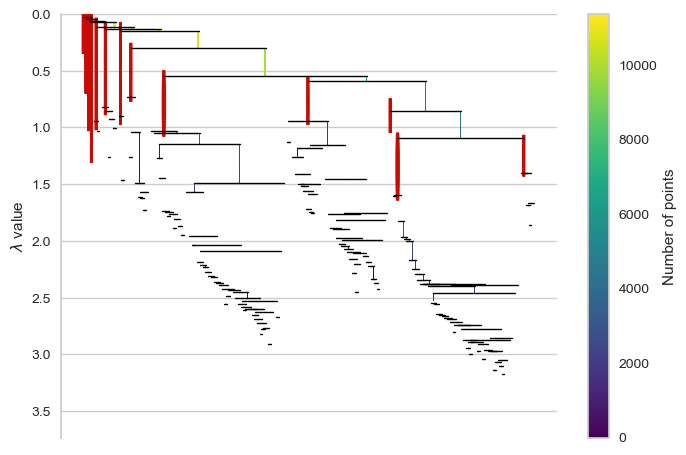

In [29]:
import hdbscan
hdbscan = hdbscan.HDBSCAN(min_cluster_size = 5, min_samples = 5)
#HDBSCAN on PCA components
hdb_clusters_PCs = hdbscan.fit_predict(pca_comps)
hdbscan.condensed_tree_.plot(select_clusters=True)
np.unique(hdb_clusters_PCs)

HDBSCAN for important PCs created 13 clusters + noise.

### 5.2 Important features

#### 5.2.1 Grid search

In [30]:
import hdbscan
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score

# Giving a range of values to search for both parameters
min_cluster_size_range = [5, 10, 15, 20]
min_samples_range = [5, 10, 15, 20]

# Create a parameter grid
param_grid = {'min_cluster_size': min_cluster_size_range,
              'min_samples': min_samples_range}

# Convert the grid to a list of dictionaries
param_combinations = list(ParameterGrid(param_grid))

# Initialize variables to store the best parameters
best_params = {}

# Iterate through each parameter combination
for params in param_combinations:
    # Create an HDBSCAN instance with the current parameters
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=params['min_cluster_size'], min_samples=params['min_samples'])
    
    # Fit the model on your data (assuming pca_comps is your data)
    hdb_clusters_ImpFeatures = hdbscan_model.fit_predict(df_scaled[most_important_features])
    
    # Check if the model has more than one cluster (-1 is noise)
    if len(np.unique(hdb_clusters_ImpFeatures)) > 1:
        # Store the parameters if the condition is met
        best_params = params
        break  # Break out of the loop after finding the first valid parameter combination

# Output the best parameters
print("Best Parameters:", best_params)

Best Parameters: {'min_cluster_size': 5, 'min_samples': 5}


#### 5.2.2 Building final model

We are building the HDBSCAN model with the best parameters: min_cluster_size = 5 and min_samples = 5.

array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int64)

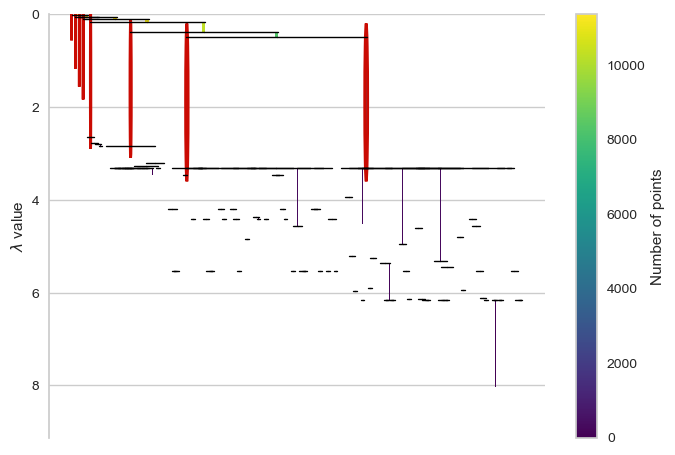

In [31]:
import hdbscan 
hdbscan = hdbscan.HDBSCAN(min_cluster_size = k, min_samples = 5) 
#HDBSCAN on Important Features
hdb_clusters_ImpFeatures = hdbscan.fit_predict(df_scaled[most_important_features])
hdbscan.condensed_tree_.plot(select_clusters=True)
np.unique(hdb_clusters_ImpFeatures)

HDBSCAN on important features created 8 clusters + noise.

### 5.3 Model evaluation

In [32]:
# metrics from imporant PC features method
dbi.append(metrics.davies_bouldin_score(pca_comps, hdb_clusters_PCs))
clusteting_methods.append('HDBSCAN_on_PCs')

# metrics from imporant features from PCA method
dbi.append(metrics.davies_bouldin_score(df_scaled[most_important_features], hdb_clusters_ImpFeatures))
clusteting_methods.append('HDBSCAN_on_ImpFeatures')

# Creating a pandas dataframe
d = {'DBI': dbi, 'clusteting_methods':clusteting_methods}
df_metrics = pd.DataFrame(d)
df_metrics.set_index('clusteting_methods', inplace = True)
df_metrics

,DBI
clusteting_methods,
Kmean_on_PCs,0.629029
Kmean_on_ImpFeatures,0.539409
DBSCAN_on_PCs,1.993556
DBSCAN_on_ImpFeatures,2.392679
HDBSCAN_on_PCs,1.221300
HDBSCAN_on_ImpFeatures,1.153284


Also after the HDBSCAN, the K-means on important features remains the best model.

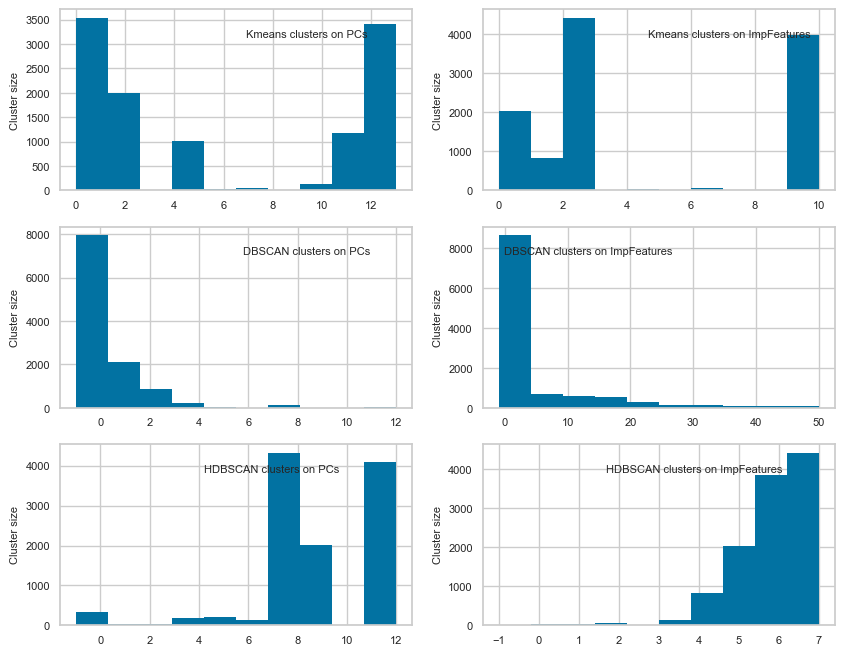

In [33]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(3,2)
fig = plt.figure(figsize=(10, 8), dpi=100)
ax1=fig.add_subplot(gs[0,0])
ax2=fig.add_subplot(gs[0,1])
ax3=fig.add_subplot(gs[1,0])
ax4=fig.add_subplot(gs[1,1])
ax5=fig.add_subplot(gs[2,0])
ax6=fig.add_subplot(gs[2,1])

ax1.hist(Kmeans_clusters_PCs)
ax1.set_title('Kmeans clusters on PCs', fontsize = 8, x=0.7, y=0.8)
ax1.set_ylabel('Cluster size', fontsize = 8)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax2.hist(Kmeans_clusters_ImpFeatures)
ax2.set_title('Kmeans clusters on ImpFeatures', fontsize = 8, x=0.7, y=0.8)
ax2.set_ylabel('Cluster size', fontsize = 8)
ax2.tick_params(axis='both', which='major', labelsize=8)

ax3.hist(db_clusters_PCs)
ax3.set_title('DBSCAN clusters on PCs', fontsize = 8, x=0.7, y=0.8)
ax3.set_ylabel('Cluster size', fontsize = 8)
ax3.tick_params(axis='both', which='major', labelsize=8)

ax4.hist(db_clusters_ImpFeatures)
ax4.set_title('DBSCAN clusters on ImpFeatures', fontsize = 8, x=0.3, y=0.8)
ax4.set_ylabel('Cluster size', fontsize = 8)
ax4.tick_params(axis='both', which='major', labelsize=8)

ax5.hist(hdb_clusters_PCs)
ax5.set_title('HDBSCAN clusters on PCs', fontsize = 8, x=0.6, y=0.8)
ax5.set_ylabel('Cluster size', fontsize = 8)
ax5.tick_params(axis='both', which='major', labelsize=8)

ax6.hist(hdb_clusters_ImpFeatures)
ax6.set_title('HDBSCAN clusters on ImpFeatures', fontsize = 8, x=0.6, y=0.8)
ax6.set_ylabel('Cluster size', fontsize = 8)
ax6.tick_params(axis='both', which='major', labelsize=8)

plt.show()

**Conclusion:** 

K-means clusters on PCs: 2 of the clusters contain the majority of the datapoints additional to 3 smaller clusters. The remaining clusters are relly small taking only a few percentages in total.

K-means clusters on ImpFeatures: This model got the highest score. The cluster sizes vary here as well, with a two dominant clusters and 2 a bit smaller clusters. The others are include just a few datapoints each.

DBSCAN clusters on PCs: There is a very large cluster indicating that DBSCAN has grouped a significant majority of the data points into one cluster, with a few very small clusters besides.

DBSCAN clusters on ImpFeatures: This shows an even more extreme result with almost all data points falling into one large cluster, and a long tail of small clusters, suggesting that DBSCAN has a large 'noise' cluster and then many small clusters.

HDBSCAN clusters on PCs: The distribution of cluster sizes is more varied, with some clusters being relatively large and others quite small. There are around 13 clusters plus noise, with no single cluster dominating.

HDBSCAN clusters on ImpFeatures: There is a gradual increase in cluster sizes, with a clear progression from small to larger clusters. The number of clusters here is 8 plus noise, and unlike in the DBSCAN case, there isn't one overwhelmingly large cluster.

### 6. Model interpretation

In [34]:
# We will take the HDBSCAN_on_ImpFeatures as the best performing model.
#adding the cluster column to the original dataset
movie_df['cluster'] = Kmeans_clusters_ImpFeatures
movie_df.head()

,studio,director,metascore,userscore,Age,RelMonth,top_actors_count,Drama,Comedy,Thriller,...,rating_ NR,rating_ Not Rated,rating_ PG-13,rating_ PG-13`,rating_ R,rating_ TV-14,rating_ TV-G,rating_ TV-MA,rating_ TV-PG,cluster
0,0,0,70,7.097753,13,6,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,1,1,76,7.700000,8,3,1,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,2,54,5.800000,18,12,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9
3,3,3,61,6.900000,12,9,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9
4,4,4,63,7.500000,11,6,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


### 6.1 Cluster Summary

c:\Users\leath\anaconda3\python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


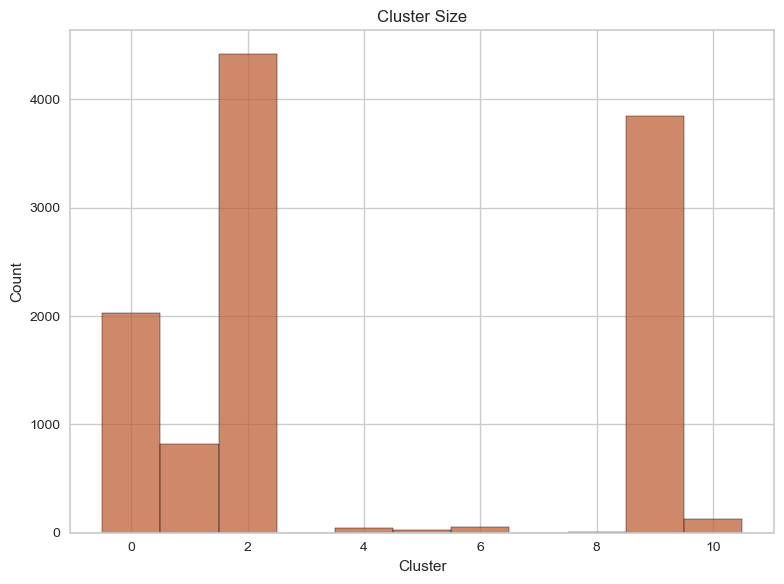

In [35]:
import matplotlib.gridspec as gridspec

# Cluster size plot
plt.figure(figsize=(8, 6))
sns.histplot(data=movie_df, x="cluster", discrete=True, color='#be6238')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Size')
plt.tight_layout()
plt.show()
plt.savefig('cluster_size.png')
plt.close()


Conclusion:

- Total of 11 clusters identified 
- Cluster 2 and 9 have the highest count of datapoints, significantly larger than the rest, suggesting them to be the predominant clusters.
- Cluster 0 is the third largest, containing around half the number of data points as the two largest.
- The rest of the clusters are significantly smaller
- The clustering result indicates two main groups (clusters 2 and 9) with a high number of data points, while the remaining clusters might represent smaller or more scattered groups. This could imply a data distribution with two main categories or the clustering algorithm's propensity towards creating clusters with a skewed size distribution.

c:\Users\leath\anaconda3\python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


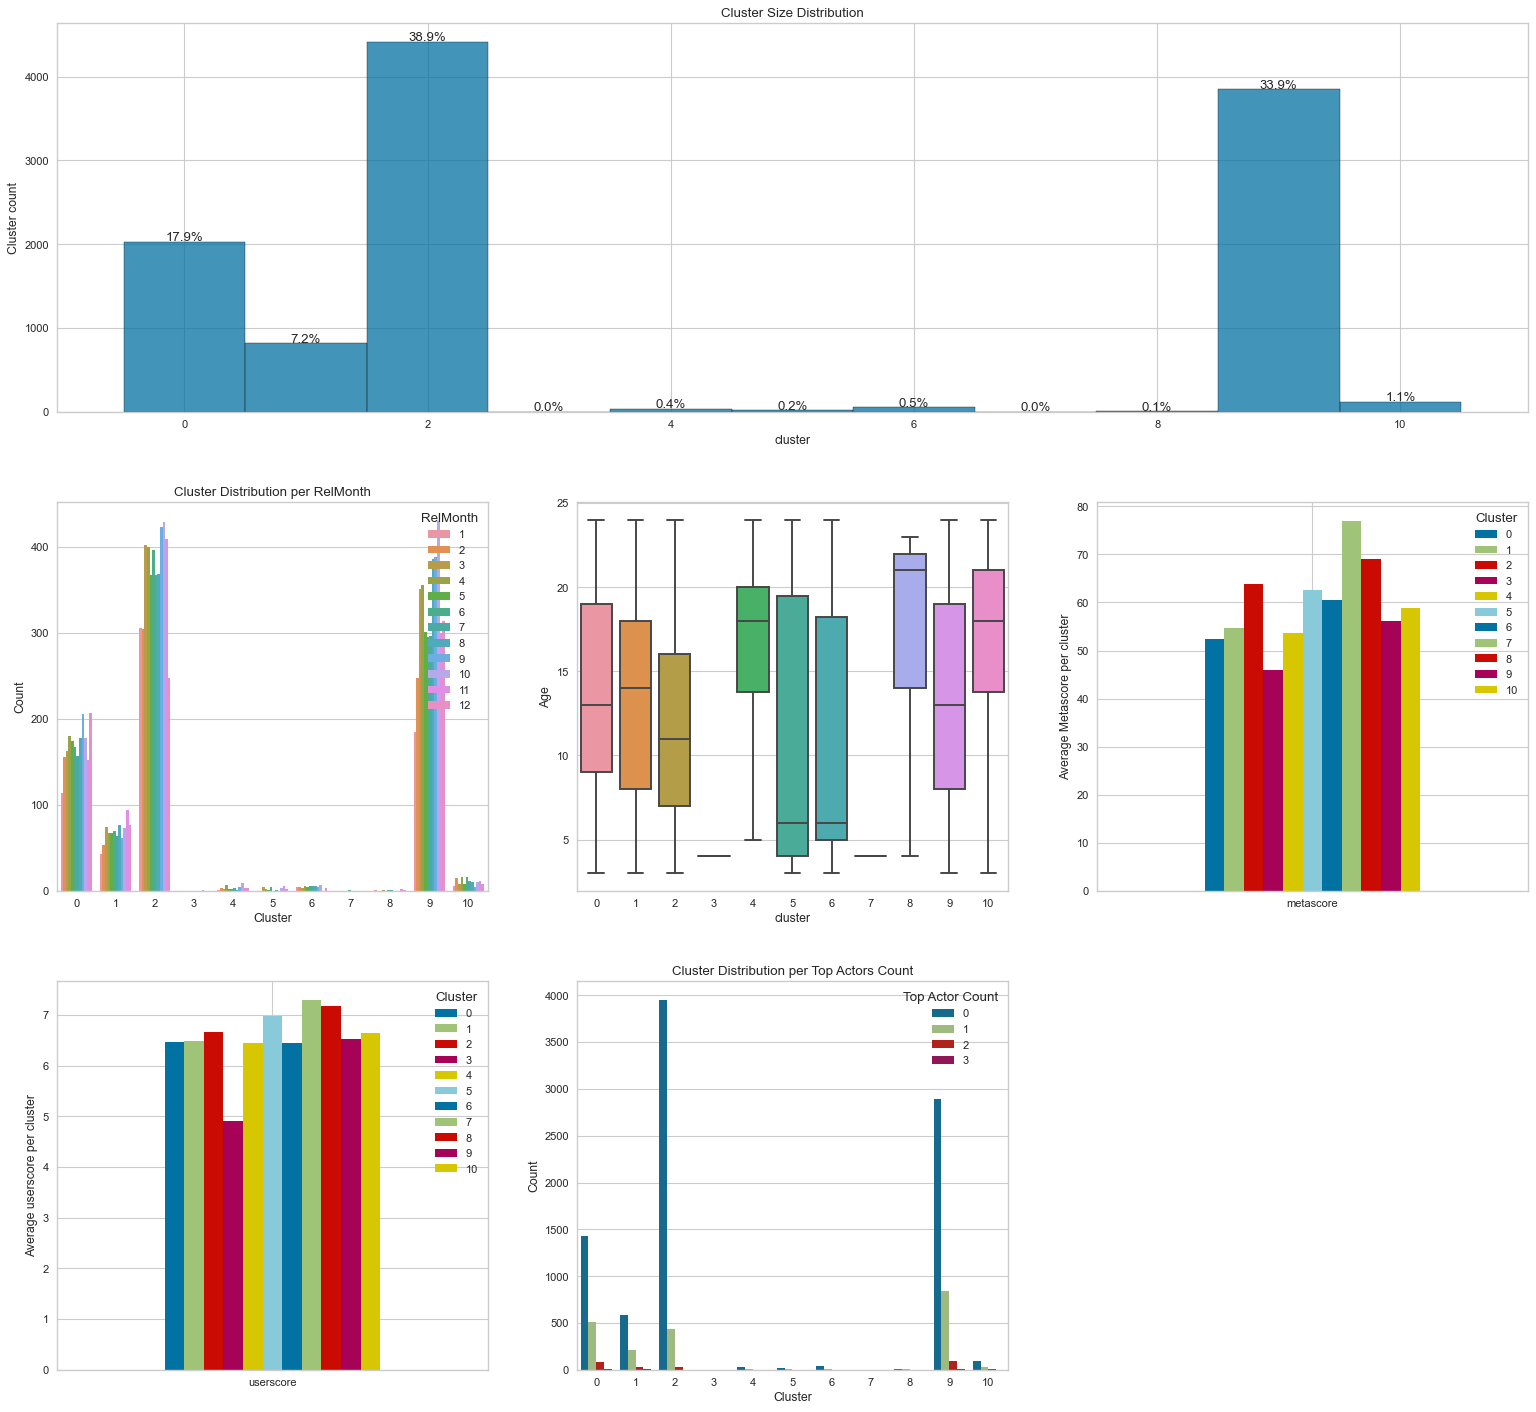

In [36]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd

# Set up the grid layout for subplots
gs = gridspec.GridSpec(5, 3)
fig = plt.figure(figsize=(20, 30), dpi=80)  

# Define subplots
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])

# Plotting each subplot
# Cluster size plot
sns.histplot(data=movie_df, x="cluster", discrete=True, ax=ax1)
for p in ax1.patches:
    ax1.annotate('{:.1f}%'.format((p.get_height()/len(movie_df))*100), (p.get_x() + 0.5, p.get_height() + 10), ha='center')
ax1.set_ylabel('Cluster count')
ax1.set_title('Cluster Size Distribution')

# RelMonth per cluster
sns.countplot(data=movie_df, x="cluster", hue="RelMonth", ax=ax2)
ax2.set_title('Cluster Distribution per RelMonth')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Count')
ax2.legend(title='RelMonth', loc='upper right', bbox_to_anchor=(1, 1), fontsize=10)

# Age per cluster 
sns.boxplot(data=movie_df, y='Age', x='cluster', ax=ax3)

# Average Metascore per cluster
average_metascore = movie_df.groupby("cluster")[['metascore']].mean().T
average_metascore.plot(kind='bar', rot=0, ax=ax4)
ax4.set_ylabel('Average Metascore per cluster')
ax4.legend(title="Cluster", loc='upper right', bbox_to_anchor=(1, 1), fontsize=10)

# Average Userscore per cluster
average_userscore = movie_df.groupby("cluster")[['userscore']].mean().T
average_userscore.plot(kind='bar', rot=0, ax=ax5)
ax5.set_ylabel('Average userscore per cluster')
ax5.legend(title="Cluster", loc='upper right', bbox_to_anchor=(1, 1), fontsize=10)

# top_actors_count per cluster
sns.countplot(data=movie_df, x="cluster", hue="top_actors_count", ax=ax6)
ax6.set_title('Cluster Distribution per Top Actors Count')
ax6.set_xlabel('Cluster')
ax6.set_ylabel('Count')
ax6.legend(title='Top Actor Count', loc='upper right', bbox_to_anchor=(1, 1), fontsize=10)

plt.tight_layout(pad=3.0)  
plt.show()



### 6.2 Answers on the research question and sub-questions

1 - Which model performs best at profiling movies based on their characteristics?

When looking at the model evaluation, based on the DBI score, the K-mean model generally performs better than the DBSCAN and HDBSCAN model.

2 - Do the models perform better by reducing dimensinality on PCs or important features?

For K-mean and HDBSCAN, the dimensinality reduction based on important features results in a better DBI Score. For DBSCAN, the reduction on PCs brings a better performance of the model.

3 - How can the age of the movies be used for creating movie profiles?

The variability in movie ages across the clusters suggests a diverse range of films, from recent releases to older classics. Some clusters are characterized by a tight grouping of release years, hinting at a more specific profile of movies, possibly centered around a particular era or trend. Others display a broader span of ages, indicating a mix of films that could cater to varied tastes. This diversity in age can be a critical factor in understanding audience preferences, which, in turn, could influence the accuracy of predictive algorithms and the personalization of movie recommendations. The clusters 4, 8 and 10 have an age distribution with more older movies with a median of 18 and 21. Clusters 5 and 6 have a more wide spread distribution with the median on the younger movies around 6. The median of the clusters 0, 1, 2 and 9 is between 11 and 14.

4 - How can the userscore be used for creating movie profiles?

The userscore appears to be fairly consistent across the different film profiles. This suggests that audience reception, as measured by the userscore, does not vary significantly between different film profiles in this dataset. Therefore, the userscore cannot be used for idenfying movie profiles.

5 - How can the metascore be used for creating movie profiles?

The metascore distribution shows more variability across film profiles compared to the userscore. Some profiles have higher average metascores, while others are lower. This suggests that critic perceptions, as measured by the metascore, do vary between different film profiles and could be a distinguishing factor in the profiling.

6 - How can the release month be used for creating movie profiles?

The histogram indicates that the release month distribution does vary across different film profiles. Some profiles are more prevalent in certain months, which could be due to seasonal trends in film releases (like summer blockbusters or award season releases). Some clusters have higher counts in specific months. Also, certain clusters have a higher count across several months, indicating that films within these clusters are released more consistently throughout the year. This suggest that these clusters may represent more mainstream or genre-specific films that do not rely on seasonal trends.
The distribution of films across different months within a single cluster indicates how broad or narrow the profile is. A broad spread across many months suggests a generalist profile, whereas a narrow spread indicates a more specialized or niche profile. By comparing the release month distribution of different clusters, one could infer the targeting strategies of different types of films. 

7 - How can the amount of top actors be used for creating movie profiles?

The graph shows that most profiles have a higher frequency of films with no top actor, with a steep drop-off for films with one, two or three top actors. This pattern is consistent across the film profiles, suggesting that the presence of top actors is a common characteristic in the dataset but does not vary much between different profiles.

**Main Research Question: How can movie profiling, based on a comprehensive set of characteristics, facilitate more accurate predictions and personalised recommendations for different audience preferences?**

Movie profiling, as indicated by the clustering of films based on attributes like age, metascores, and potentially other unobserved characteristics, delineates distinct groups within the movie database. This understanding allows for the identification of unique patterns and preferences within each cluster. By leveraging these insights, we can refine predictive models to forecast viewer preferences with greater accuracy and tailor recommendations more effectively, ensuring they resonate with the specific tastes and expectations of diverse audience segments.

Looking at cluster 2 for example, the movie profile contains movies that have, considering the percentage of datapoints its containing, quite high userscores and metascores and are therefore popular among users and critics. Compared to other clusters, the proportion of a top actor count of zero is quite high, which means hat in order for a movie to receive high ratings, the considered top actors are not necessary to be involved in a movie. Most movies of that cluster are also between 7 and 16 years old. As the distribution of the release month is quite equal among all clusters, there is no particular month standing out for this cluster.